# Remaining Life Prediction for Turbofan Engine - Regression

## Data Exploration

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from turbofan_importFDdata import turbofan_importFDdata

**Loading the dataset FD002**

In [56]:
data = turbofan_importFDdata('train_FD002.txt')
data

,Unit,Time,Setting1,Setting2,Setting3,FanInletTemp,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,FanInletPres,...,FuelFlowRatio,CorrFanSpeed,CorrCoreSpeed,BypassRatio,BurnerFuelAirRatio,BleedEnthalpy,DemandFanSpeed,DemandCorrFanSpeed,HPTCoolantBleed,LPTCoolantBleed
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,312,20.0037,0.7000,100.0,491.19,608.79,1495.60,1269.51,9.35,...,314.05,2389.02,8169.64,9.3035,0.03,369,2324,100.00,24.36,14.5189
53755,260,313,10.0022,0.2510,100.0,489.05,605.81,1514.32,1324.12,10.52,...,371.22,2388.42,8245.36,8.7586,0.03,374,2319,100.00,28.10,16.9454
53756,260,314,25.0041,0.6200,60.0,462.54,537.48,1276.24,1057.92,7.05,...,163.74,2030.33,7971.25,11.0657,0.02,310,1915,84.93,14.19,8.5503
53757,260,315,25.0033,0.6220,60.0,462.54,537.84,1272.95,1066.30,7.05,...,164.37,2030.35,7972.47,11.0537,0.02,311,1915,84.93,14.05,8.3729


**Overview on all sensor measurments for all units**

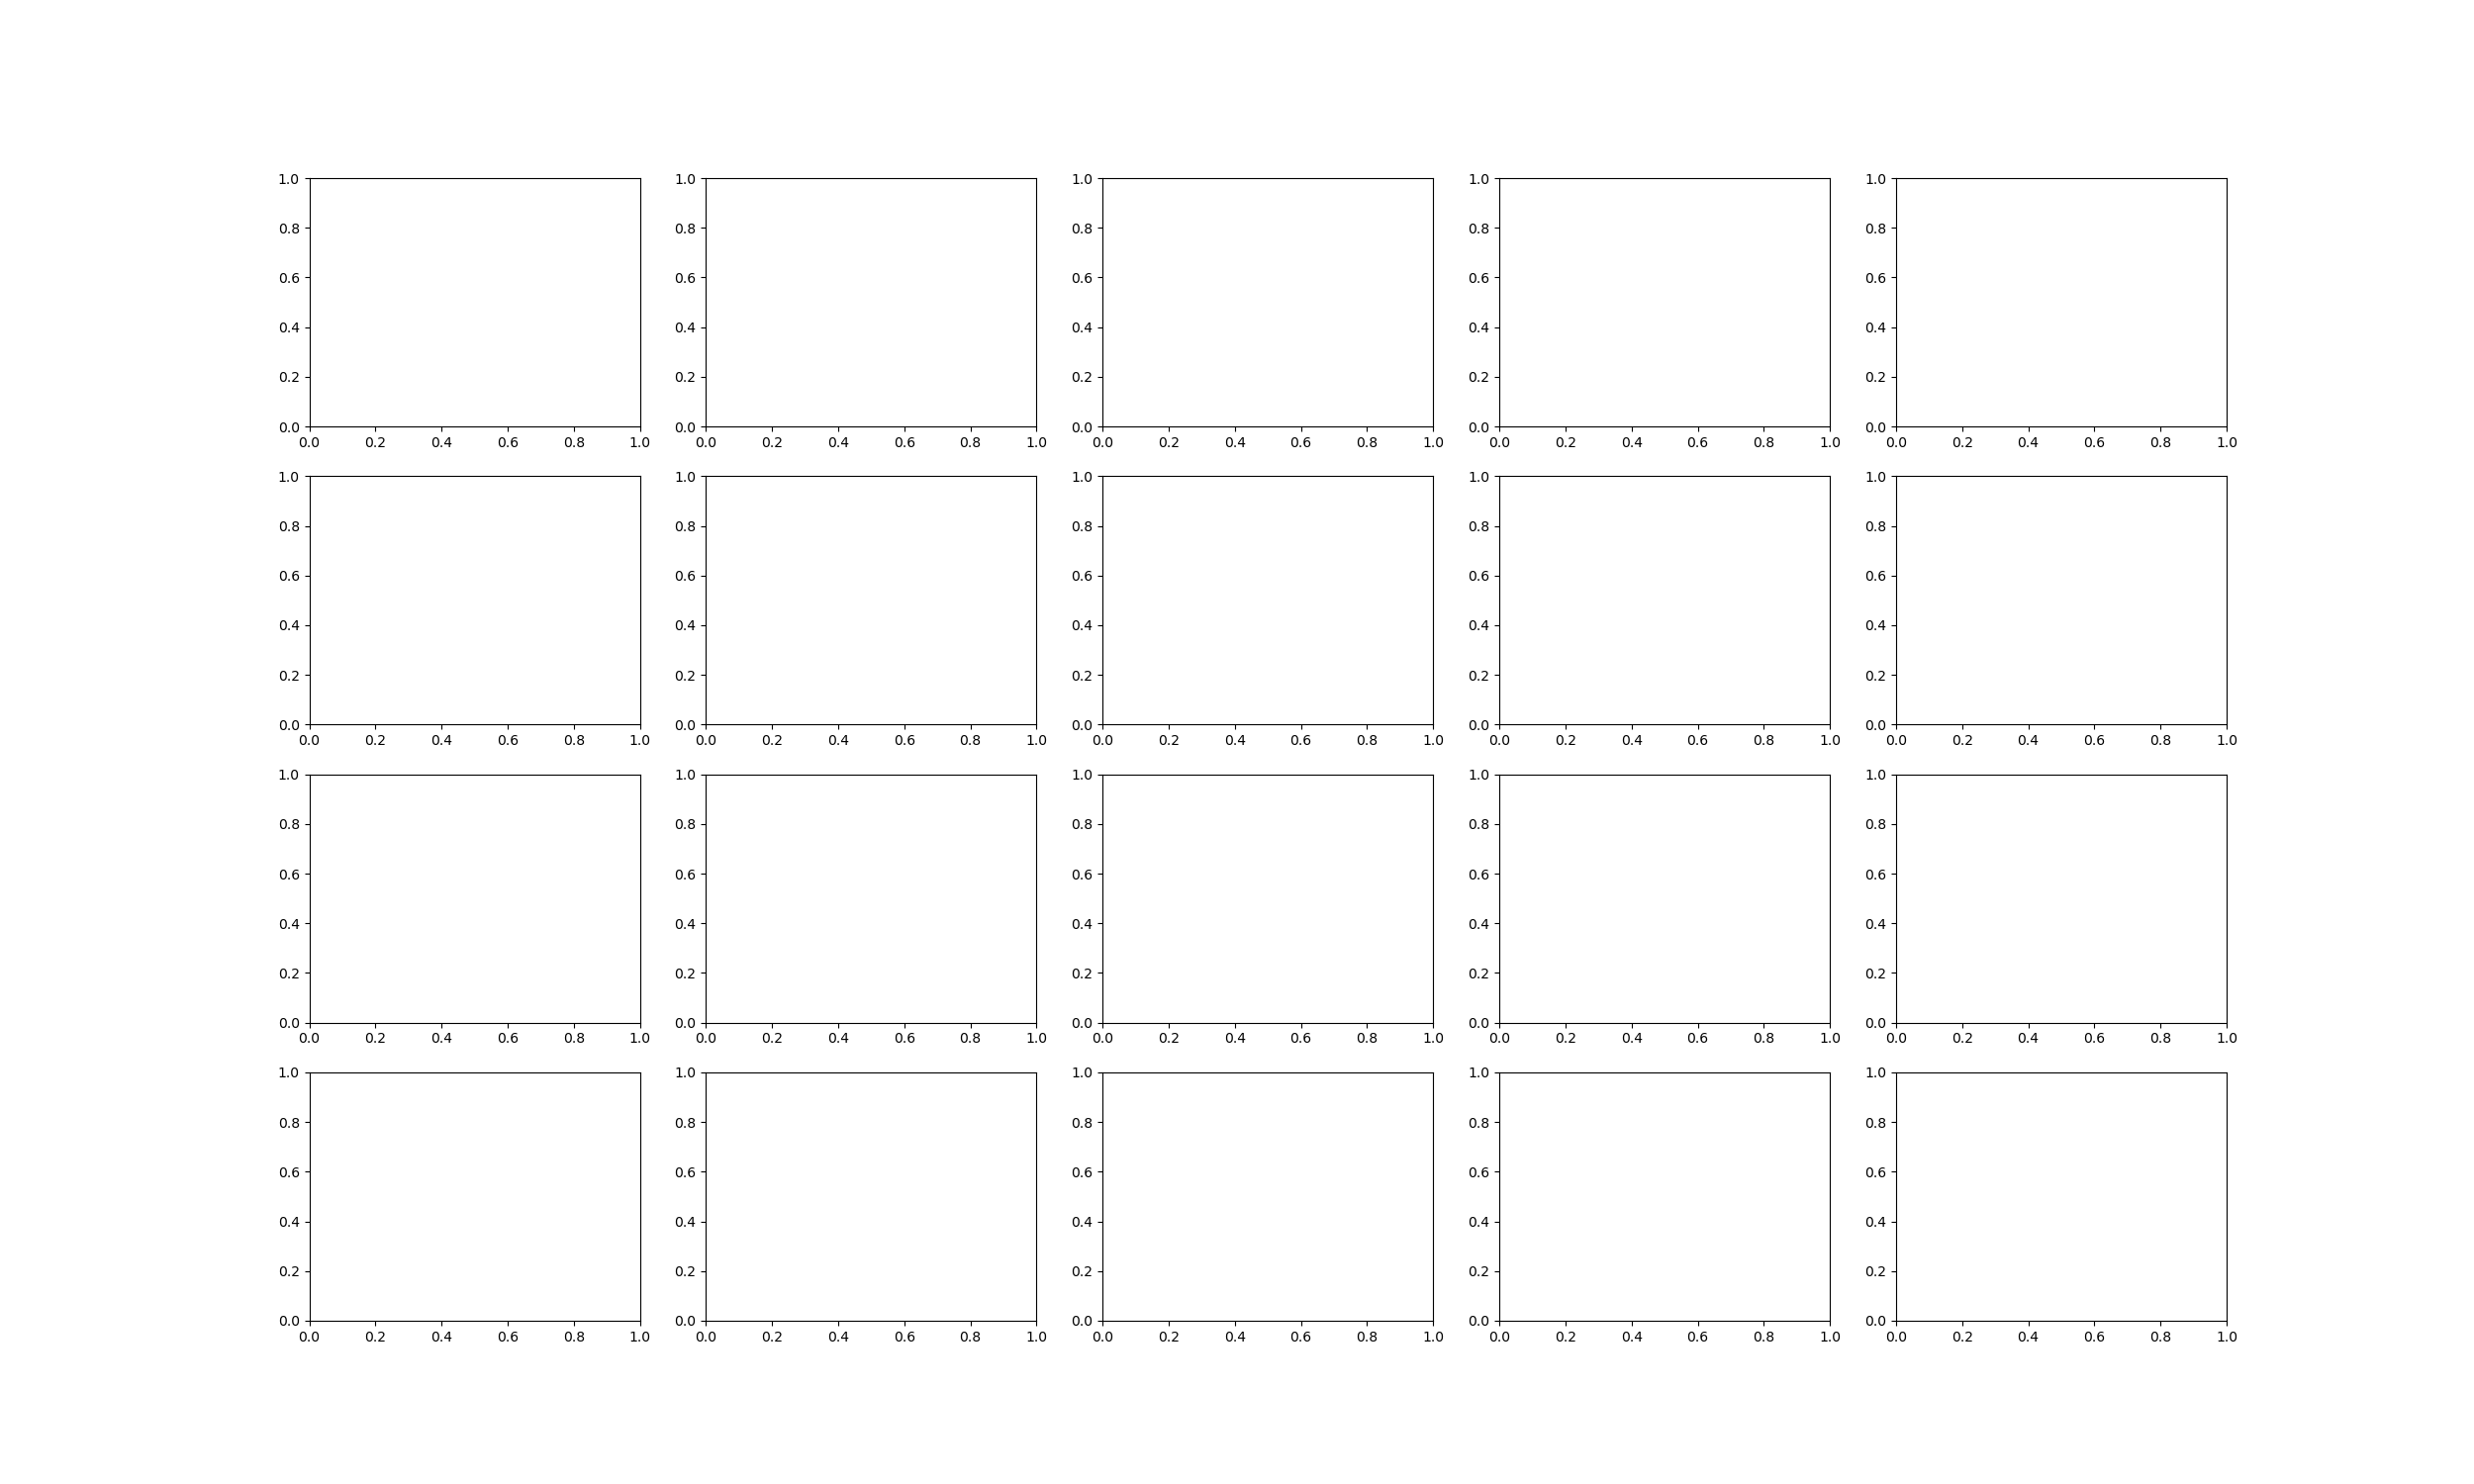

In [57]:
fig, axs = plt.subplots(4, 5)
fig.set_figheight(15)
fig.set_figwidth(25)

# iterate over units

#for u in range(260): 
#    # iterate over sensor measurments
#    for s in range(5):
#        axs[0,s].scatter(data.loc[data.Unit==u+1, 'Time'], data.loc[data.Unit==u+1, data.columns[s+5]])
#        axs[0,s].set_title(data.columns[s+5])
#    for s in range(5): 
#        axs[1,s].scatter(data.loc[data.Unit==u+1, 'Time'], data.loc[data.Unit==u+1, data.columns[s+10]])
#        axs[1,s].set_title(data.columns[s+10])
#    for s in range(5):
#        axs[2,s].scatter(data.loc[data.Unit==u+1, 'Time'], data.loc[data.Unit==u+1, data.columns[s+15]])
#        axs[2,s].set_title(data.columns[s+15])
#    for s in range(5):
#        axs[3,s].scatter(data.loc[data.Unit==u+1, 'Time'], data.loc[data.Unit==u+1, data.columns[s+20]])
#        axs[3,s].set_title(data.columns[s+20])

**Determining the operation mode from the operational Settings**  
We can compute and round the average of the three settings to determine the different operation modes:

In [58]:
modi = np.round((data.loc[:,'Setting1'] + data.loc[:,'Setting2'] + data.loc[:,'Setting3']) /3)
print(f'Unique modes: {modi.unique()}')

Unique modes: [45. 48. 29. 40. 33. 37.]


We can also view that by clustering the settings:

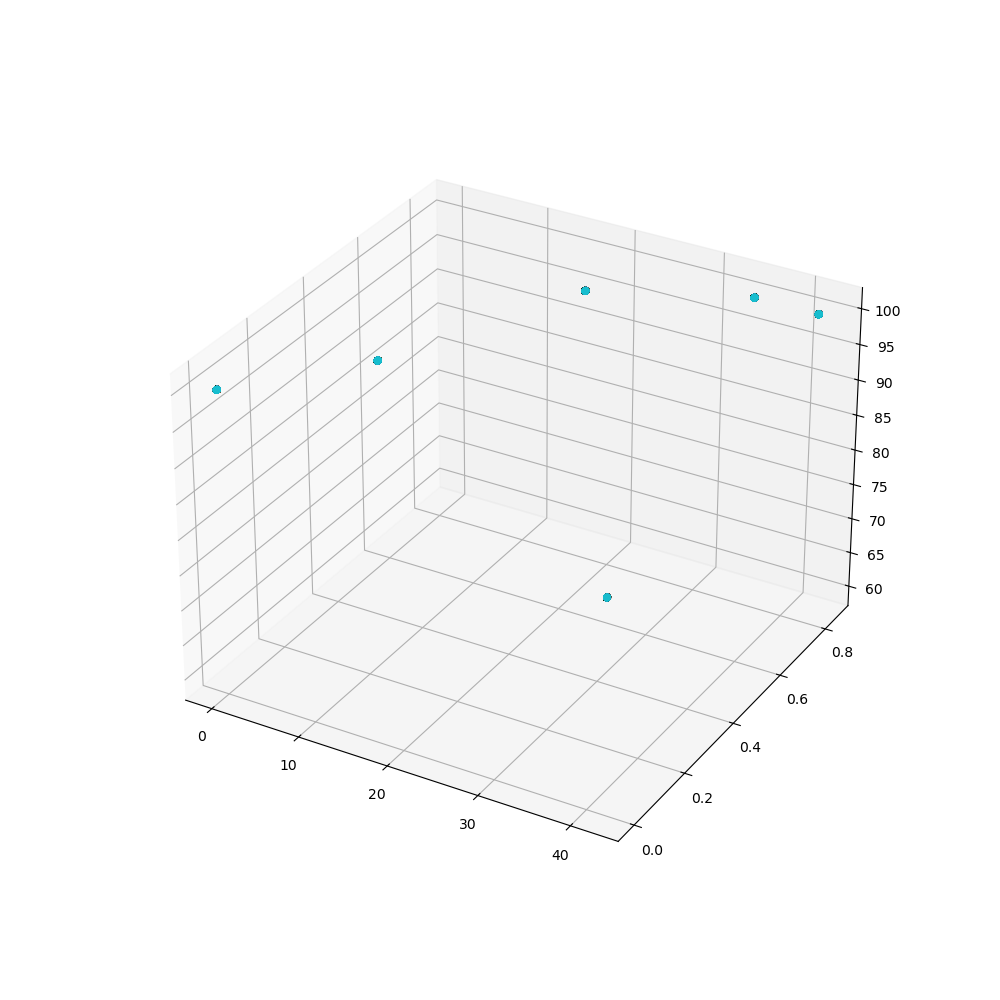

In [59]:
data_per_engine = data.groupby('Unit')
data_per_engine = [data_per_engine.get_group(x) for x in data_per_engine.groups]

fig = plt.figure(figsize=(10, 10))
#add 3d scatter plot
ax = fig.add_subplot(111, projection='3d')
for i, engine_data in enumerate(data_per_engine):
    ax.scatter(engine_data['Setting1'], engine_data['Setting2'], engine_data['Setting3'])

We now add a column containing the operation mode:

In [60]:
data.drop('Setting1', inplace=True, axis=1)
data.drop('Setting2', inplace=True, axis=1)
data.drop('Setting3', inplace=True, axis=1)
data.insert(2, 'Modi', modi)
data.loc[data.Modi == 29, 'Modi'] = 1
data.loc[data.Modi == 33, 'Modi'] = 2
data.loc[data.Modi == 37, 'Modi'] = 3
data.loc[data.Modi == 40, 'Modi'] = 4
data.loc[data.Modi == 45, 'Modi'] = 5
data.loc[data.Modi == 48, 'Modi'] = 6

In [61]:
data

,Unit,Time,Modi,FanInletTemp,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,FanInletPres,BypassDuctPres,TotalHPCOutletPres,...,FuelFlowRatio,CorrFanSpeed,CorrCoreSpeed,BypassRatio,BurnerFuelAirRatio,BleedEnthalpy,DemandFanSpeed,DemandCorrFanSpeed,HPTCoolantBleed,LPTCoolantBleed
0,1,1,5.0,449.44,555.32,1358.61,1137.23,5.48,8.00,194.64,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,6.0,445.00,549.90,1353.22,1125.78,3.91,5.71,138.51,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,1.0,462.54,537.31,1256.76,1047.45,7.05,9.02,175.71,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,6.0,445.00,549.51,1354.03,1126.38,3.91,5.71,138.46,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,1.0,462.54,537.07,1257.71,1047.93,7.05,9.03,175.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,312,4.0,491.19,608.79,1495.60,1269.51,9.35,13.66,334.00,...,314.05,2389.02,8169.64,9.3035,0.03,369,2324,100.00,24.36,14.5189
53755,260,313,3.0,489.05,605.81,1514.32,1324.12,10.52,15.50,392.46,...,371.22,2388.42,8245.36,8.7586,0.03,374,2319,100.00,28.10,16.9454
53756,260,314,1.0,462.54,537.48,1276.24,1057.92,7.05,9.04,175.11,...,163.74,2030.33,7971.25,11.0657,0.02,310,1915,84.93,14.19,8.5503
53757,260,315,1.0,462.54,537.84,1272.95,1066.30,7.05,9.04,174.81,...,164.37,2030.35,7972.47,11.0537,0.02,311,1915,84.93,14.05,8.3729


## Data Preparation
**Shift the time variable to a count down timer for remaining cycles to failure**

In [62]:
for i in range(1,261):
    data.loc[data.Unit == i] = data.loc[data.Unit == i].assign(Time=data.loc[data.Unit == i].loc[:,"Time"].max()-data.loc[data.Unit == i].loc[:,"Time"])

**Data Standardization**

In [63]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = pd.concat([data.iloc[:,0:3], pd.DataFrame(scaler.fit_transform(data.iloc[:,3:]))], axis=1)

**Add labels to the instances of the training set reflecting urgency indicators**

In [64]:
data = data.assign(Urgency = pd.cut(data['Time'], bins=[-1, 51, 126, 201, 1000], labels=['Urg', 'Short', 'Med', 'Long']))
data

,Unit,Time,Modi,0,1,2,3,4,5,6,...,12,13,14,15,16,17,18,19,20,Urgency
0,1,148,5.0,-0.889378,-0.653071,-0.579176,-0.572622,-0.706177,-0.662907,-0.602496,...,0.415116,-0.212615,0.021948,-0.705933,-0.515579,-0.039954,0.418187,-0.613958,-0.619148,Med
1,1,147,6.0,-1.057627,-0.798422,-0.630051,-0.668741,-1.140622,-1.084502,-0.986938,...,0.414648,0.067215,0.063719,-0.705933,-0.659701,-0.115645,0.418187,-1.051681,-1.048190,Med
2,1,146,1.0,-0.392968,-1.136055,-1.540521,-1.326301,-0.271732,-0.475122,-0.732150,...,-2.393490,-2.377822,2.087798,-0.705933,-1.416342,-2.159318,-2.391275,-0.679819,-0.641912,Med
3,1,145,6.0,-1.057627,-0.808881,-0.622406,-0.663705,-1.140622,-1.084502,-0.987280,...,0.414257,0.024309,0.030890,-0.705933,-0.695731,-0.115645,0.418187,-1.033443,-1.013808,Med
4,1,144,1.0,-0.392968,-1.142491,-1.531554,-1.322271,-0.271732,-0.473281,-0.736670,...,-2.393724,-2.420728,2.090734,-0.705933,-1.416342,-2.159318,-2.391275,-0.674753,-0.666180,Med
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,4,4.0,0.692693,0.780862,0.713849,0.537834,0.364716,0.379114,0.351999,...,0.425267,1.214589,-0.034903,1.416565,0.745489,0.655032,0.418187,0.361801,0.345429,Urg
53755,260,3,3.0,0.611600,0.700946,0.890544,0.996270,0.688475,0.717863,0.752399,...,0.420582,2.107123,-0.762087,1.416565,0.925641,0.620627,0.418187,0.740757,0.755203,Urg
53756,260,2,1.0,-0.392968,-1.131496,-1.356652,-1.238408,-0.271732,-0.471440,-0.736259,...,-2.375530,-1.123891,2.316803,-0.705933,-1.380311,-2.159318,-2.391275,-0.668673,-0.662515,Urg
53757,260,1,1.0,-0.392968,-1.121841,-1.387706,-1.168060,-0.271732,-0.471440,-0.738314,...,-2.375374,-1.109510,2.300789,-0.705933,-1.344281,-2.159318,-2.391275,-0.682859,-0.692473,Urg


## Modeling & Training

**PCA**

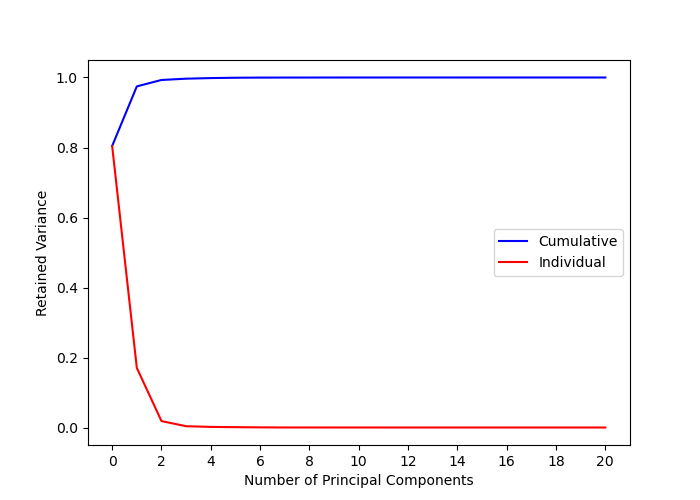

In [65]:
# PCA
Z = data.values[:, 3:-1]
pca = PCA().fit(Z)
coeff = (pca.components_).T
score = pca.transform(Z)
variance_ratio = pca.explained_variance_ratio_

fig = plt.figure(figsize=(7, 5))

n = data.shape[1] -4

# >>> enter your code here
plt.plot(range(n), variance_ratio.cumsum(), 'b-')
plt.plot(range(n), variance_ratio, 'r-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Retained Variance')
plt.xticks(range(0, 21, 2))
plt.legend(['Cumulative', 'Individual']);

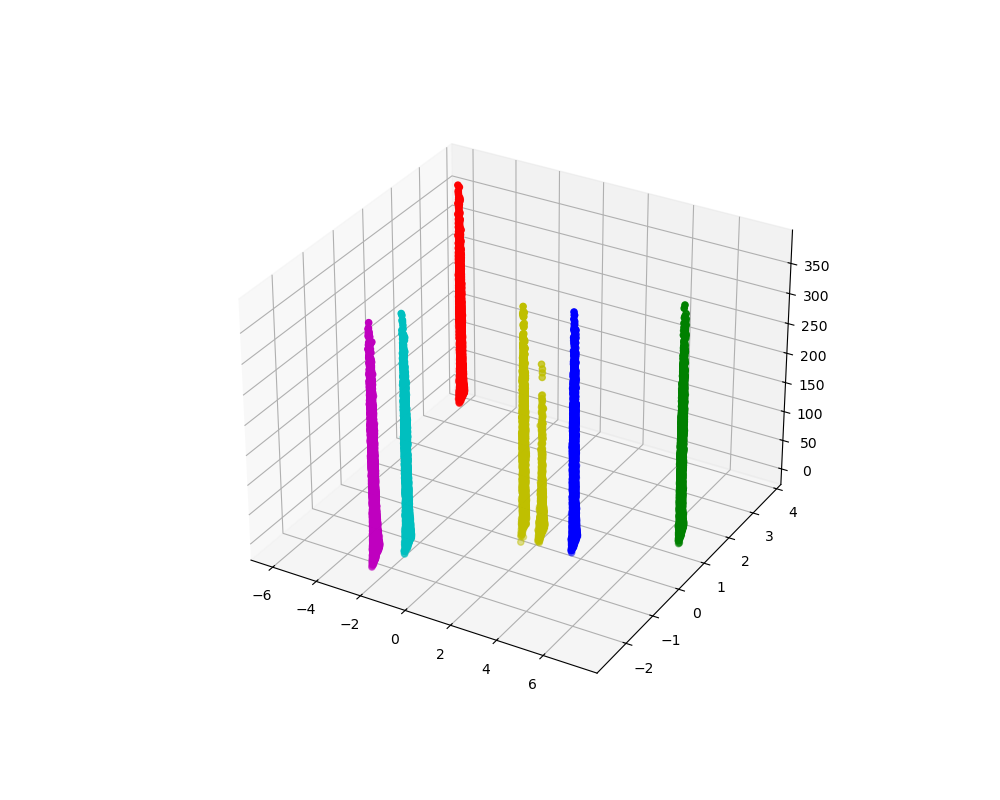

In [12]:
%matplotlib ipympl
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')
n = len(modi+1)
colors = ['r', 'g', 'b', 'y', 'c', 'm']
for i, c in enumerate(colors):
    idx = np.argwhere(data['Modi'] == i+1).squeeze()
    ax.scatter(score[idx, 0], score[idx, 1], data['Time'][idx], c=c)
#unit = np.argwhere(data.values[:, 0] == 10).squeeze()
#idx = np.argwhere(data.values[:, 2] == 1.0).squeeze()
#ax.scatter(score[idx, 0], score[idx, 1], data['Time'][idx], color='r')
#idx = np.argwhere(data.values[:, 2] == 2.0).squeeze()
#ax.scatter(score[idx, 0], score[idx, 1], data['Time'][idx], color='b')
# idx = np.argwhere(data.values[:, 2] == 3.0).squeeze()
# ax.scatter(score[unit, 0], score[unit, 1], data['Time'][unit], color='g')

Get amount of observations per mode

In [66]:
for i in range(1, 7):
    print(f'Mode {i}: {len(np.argwhere(data["Modi"] == i).squeeze())} observations')

Mode 1: 8002 observations
Mode 2: 8044 observations
Mode 3: 8096 observations
Mode 4: 8122 observations
Mode 5: 8037 observations
Mode 6: 13458 observations


Make PCA for mode 6

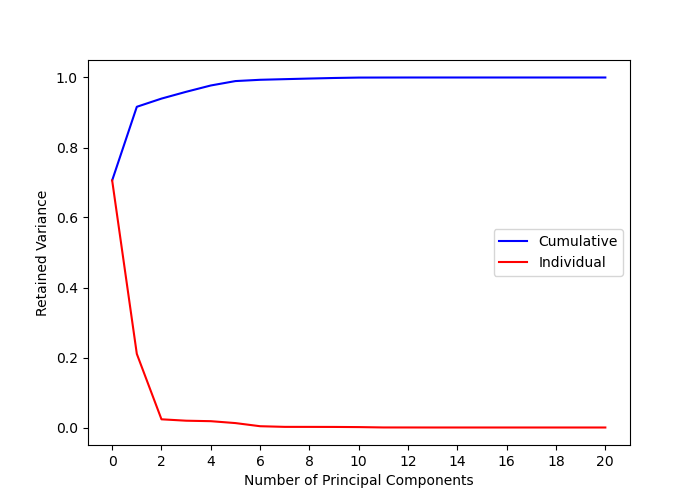

In [67]:
data_mode_six = data[data['Modi'] == 6]
Z = data_mode_six.values[:, 3:-1]
pca = PCA().fit(Z)
coeff = (pca.components_).T
score = pca.transform(Z)
variance_ratio = pca.explained_variance_ratio_

fig = plt.figure(figsize=(7, 5))

n = data.shape[1] -4

# >>> enter your code here
plt.plot(range(n), variance_ratio.cumsum(), 'b-')
plt.plot(range(n), variance_ratio, 'r-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Retained Variance')
plt.xticks(range(0, 21, 2))
plt.legend(['Cumulative', 'Individual']);

Text(0.5, 0, 'Time')

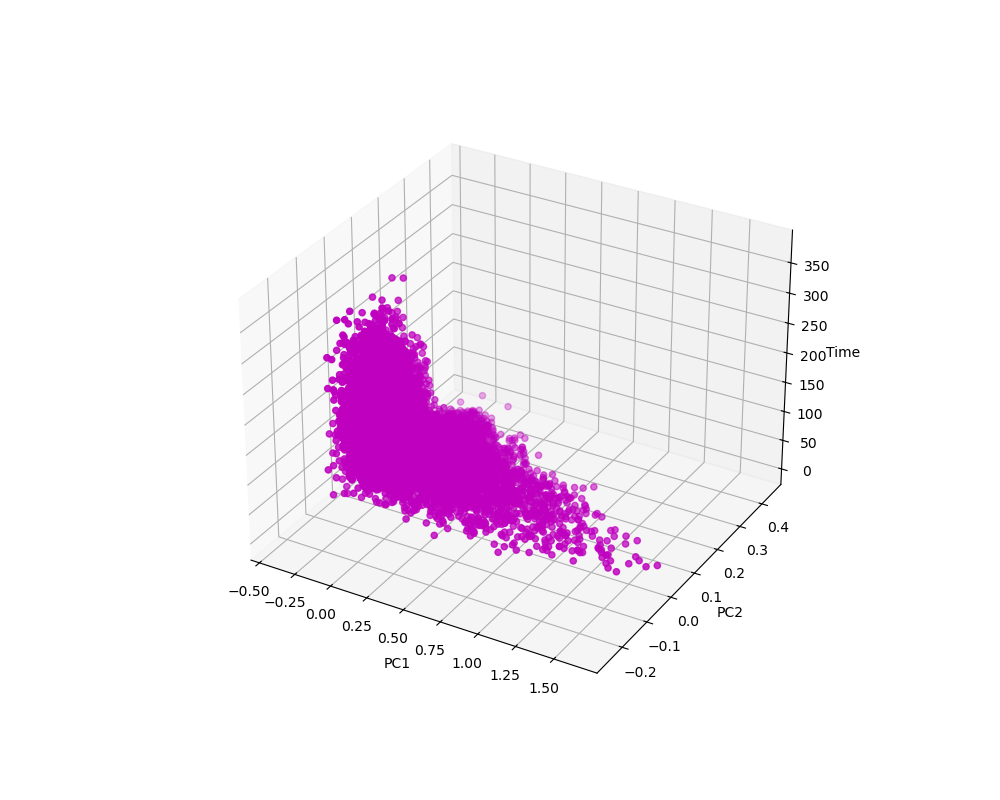

In [68]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(score[:, 0], score[:, 1], data_mode_six['Time'][:], c=c)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('Time')

Find good combination of PC1 and PC2

Text(0, 0.5, 'Time')

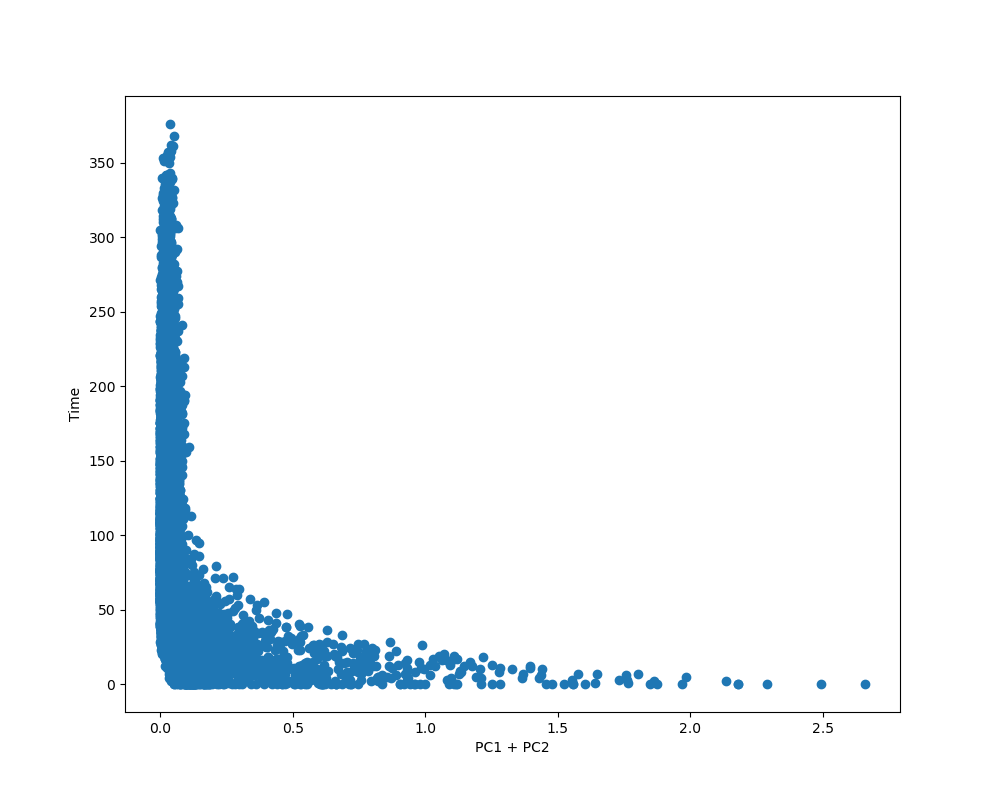

In [69]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

ax.plot(np.power(score[:, 0], 2) + np.square(score[:, 1]), data_mode_six['Time'][:], "o")
plt.xlabel('PC1 + PC2')
plt.ylabel('Time')

0.5883440133433298
(13458, 2)


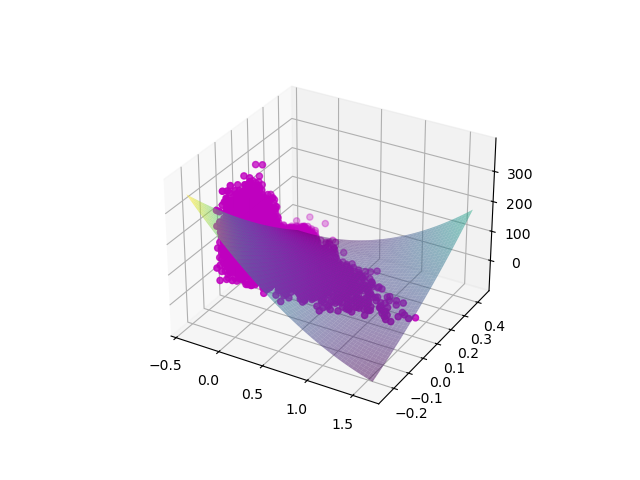

In [70]:
from linreg import solve_normaleqn, create_featurepoly, evaluate_hypothesis
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

degree = 2
input = np.array([score[:, 0], score[:, 1]]).T 
poly = PolynomialFeatures(degree=degree, include_bias=True)
poly_variables = poly.fit_transform(input)
regression = LinearRegression()
model = regression.fit(poly_variables, data_mode_six.values[:, 1])

x0_range = np.linspace(score[:, 0].min(), input[:, 0].max(), 100)
x1_range = np.linspace(score[:, 1].min(), input[:, 1].max(), 100)
x0_grid, x1_grid = np.meshgrid(x0_range, x1_range)
X_grid = np.c_[x0_grid.ravel(), x1_grid.ravel()]

y_pred_grid = model.predict(poly.fit_transform(X_grid))
y_pred_grid = y_pred_grid.reshape(x0_grid.shape)
res = model.score(poly_variables, data_mode_six['Time'])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(score[:, 0], score[:, 1], data_mode_six['Time'][:], c=c, label='Data')
ax.plot_surface(x0_grid, x1_grid, y_pred_grid, alpha=0.5, cmap='viridis', label='Fitted Plane')
print(res)
print(input.shape)

## Testing

In [71]:
test_data = turbofan_importFDdata('test_FD002.txt')
rul = np.loadtxt('RUL_FD002.txt', dtype=int)
print(rul[:10])
test_data

[ 18  79 106 110  15 155   6  90  11  79]


,Unit,Time,Setting1,Setting2,Setting3,FanInletTemp,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,FanInletPres,...,FuelFlowRatio,CorrFanSpeed,CorrCoreSpeed,BypassRatio,BurnerFuelAirRatio,BleedEnthalpy,DemandFanSpeed,DemandCorrFanSpeed,HPTCoolantBleed,LPTCoolantBleed
0,1,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,...,371.69,2388.18,8114.10,8.6476,0.03,369,2319,100.00,28.42,17.1551
1,1,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,...,315.32,2388.12,8053.06,9.2405,0.02,364,2324,100.00,24.29,14.8039
2,1,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,...,183.04,2387.75,8053.04,9.3472,0.02,333,2223,100.00,14.98,8.9125
3,1,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,...,130.40,2387.72,8066.90,9.3961,0.02,332,2212,100.00,10.35,6.4181
4,1,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,...,164.56,2028.05,7865.66,10.8682,0.02,305,1915,84.93,14.31,8.5740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33986,259,119,35.0015,0.8403,100.0,449.44,555.56,1366.01,1129.47,5.48,...,183.05,2388.39,8088.36,9.3215,0.02,334,2223,100.00,14.94,8.9065
33987,259,120,42.0066,0.8405,100.0,445.00,549.42,1351.13,1123.86,3.91,...,130.74,2388.31,8108.48,9.3542,0.02,332,2212,100.00,10.57,6.4075
33988,259,121,42.0061,0.8400,100.0,445.00,549.65,1349.14,1118.91,3.91,...,130.96,2388.34,8098.77,9.3836,0.02,331,2212,100.00,10.57,6.4805
33989,259,122,0.0024,0.0003,100.0,518.67,642.58,1589.61,1408.16,14.62,...,522.25,2388.00,8161.85,8.4279,0.03,393,2388,100.00,39.08,23.3589


In [72]:
test_data.drop('Setting1', inplace=True, axis=1)
test_data.drop('Setting2', inplace=True, axis=1)
test_data.drop('Setting3', inplace=True, axis=1)
test_data.insert(2, 'Modi', modi)
test_data.loc[test_data.Modi == 29, 'Modi'] = 1
test_data.loc[test_data.Modi == 33, 'Modi'] = 2
test_data.loc[test_data.Modi == 37, 'Modi'] = 3
test_data.loc[test_data.Modi == 40, 'Modi'] = 4
test_data.loc[test_data.Modi == 45, 'Modi'] = 5
test_data.loc[test_data.Modi == 48, 'Modi'] = 6

In [73]:
test_data

,Unit,Time,Modi,FanInletTemp,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,FanInletPres,BypassDuctPres,TotalHPCOutletPres,...,FuelFlowRatio,CorrFanSpeed,CorrCoreSpeed,BypassRatio,BurnerFuelAirRatio,BleedEnthalpy,DemandFanSpeed,DemandCorrFanSpeed,HPTCoolantBleed,LPTCoolantBleed
0,1,1,5.0,489.05,605.03,1497.17,1304.99,10.52,15.49,394.54,...,371.69,2388.18,8114.10,8.6476,0.03,369,2319,100.00,28.42,17.1551
1,1,2,6.0,491.19,607.82,1481.20,1246.11,9.35,13.66,334.36,...,315.32,2388.12,8053.06,9.2405,0.02,364,2324,100.00,24.29,14.8039
2,1,3,1.0,449.44,556.00,1359.08,1128.36,5.48,8.00,193.55,...,183.04,2387.75,8053.04,9.3472,0.02,333,2223,100.00,14.98,8.9125
3,1,4,6.0,445.00,550.17,1349.69,1127.89,3.91,5.71,138.74,...,130.40,2387.72,8066.90,9.3961,0.02,332,2212,100.00,10.35,6.4181
4,1,5,1.0,462.54,536.72,1253.18,1050.69,7.05,9.03,175.75,...,164.56,2028.05,7865.66,10.8682,0.02,305,1915,84.93,14.31,8.5740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33986,259,119,2.0,449.44,555.56,1366.01,1129.47,5.48,8.00,194.87,...,183.05,2388.39,8088.36,9.3215,0.02,334,2223,100.00,14.94,8.9065
33987,259,120,5.0,445.00,549.42,1351.13,1123.86,3.91,5.72,138.34,...,130.74,2388.31,8108.48,9.3542,0.02,332,2212,100.00,10.57,6.4075
33988,259,121,5.0,445.00,549.65,1349.14,1118.91,3.91,5.72,138.27,...,130.96,2388.34,8098.77,9.3836,0.02,331,2212,100.00,10.57,6.4805
33989,259,122,1.0,518.67,642.58,1589.61,1408.16,14.62,21.61,553.13,...,522.25,2388.00,8161.85,8.4279,0.03,393,2388,100.00,39.08,23.3589


In [74]:
test_scaler = StandardScaler()
test_data = pd.concat([test_data.iloc[:,0:3], pd.DataFrame(test_scaler.fit_transform(test_data.iloc[:,3:]))], axis=1)

**PCA of test data**

In [40]:
test_data_mode_six = test_data[test_data['Modi'] == 6]
Z_test = test_data_mode_six.values[:, 3:]
score = pca.transform(Z_test)

In [75]:
max_time_indices = test_data.groupby('Unit')['Time'].idxmax()
last_measure = test_data.loc[max_time_indices]
last_measure

,Unit,Time,Modi,0,1,2,3,4,5,6,...,11,12,13,14,15,16,17,18,19,20
257,1,258,5.0,0.609351,0.691736,0.909984,1.024747,0.684641,0.713939,0.754357,...,0.755746,0.419304,1.233734,-0.761926,1.477691,0.830763,0.619517,0.417335,0.752973,0.772056
312,2,55,4.0,1.729018,1.689369,1.633439,1.806852,1.816057,1.835699,1.845116,...,1.843559,0.417740,0.888502,-1.191033,1.477691,1.623297,1.094614,0.417335,1.814672,1.823937
477,3,165,3.0,-0.887948,-0.635585,-0.452379,-0.567018,-0.706173,-0.663018,-0.604143,...,-0.603821,0.417349,0.090557,-0.007777,-0.676731,-0.574184,-0.041487,0.417335,-0.614521,-0.596353
563,4,86,2.0,0.690245,0.760566,0.654647,0.457027,0.361773,0.376125,0.350289,...,0.350324,0.417740,-0.014897,-0.107430,-0.676731,0.614617,0.653945,0.417335,0.341211,0.366302
711,5,148,5.0,-1.055785,-0.770834,-0.562497,-0.527115,-1.139422,-1.081612,-0.987526,...,-0.982452,0.425090,0.922143,0.108595,-0.676731,-0.538160,-0.117227,0.417335,-1.059587,-1.033531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33511,255,150,3.0,-1.055785,-0.817435,-0.611847,-0.669255,-1.139422,-1.083448,-0.983021,...,-0.984914,0.417427,0.308981,0.058836,-0.676731,-0.610208,-0.117227,0.417335,-1.045458,-1.016574
33570,256,59,4.0,0.609351,0.674060,0.777880,0.882859,0.684641,0.712103,0.762890,...,0.757267,0.418287,0.777560,-0.894885,1.477691,0.758714,0.619517,0.417335,0.775175,0.794026
33769,257,199,4.0,-0.887948,-0.638263,-0.459268,-0.630528,-0.706173,-0.663018,-0.600866,...,-0.607224,0.420164,0.290133,-0.003898,-0.676731,-0.538160,-0.041487,0.417335,-0.591309,-0.615228
33867,258,98,4.0,1.729018,1.668479,1.622587,1.638670,1.816057,1.835699,1.846891,...,1.846383,0.417271,0.961032,-1.200664,1.477691,1.551248,1.094614,0.417335,1.832838,1.842912


In [102]:
cycles_pred = []
for i, row in last_measure.iterrows():
    test_score = pca.transform(row.values[3:].reshape(1, -1))
    pred = model.predict(poly.fit_transform(np.array((test_score[0, 0], test_score[0, 1])).reshape(1, -1)))
    cycles_pred.append(float(pred))

for i in range(len(rul)):
    print(f"Pred: {cycles_pred[i]} RUL: {rul[i]}")

Pred: 1685.0313813231744 RUL: 18
Pred: 3330.9659912206866 RUL: 79
Pred: 96.68563203987875 RUL: 106
Pred: 259.57947057428134 RUL: 110
Pred: 9.762513854842311 RUL: 15
Pred: 150.8953960580792 RUL: 155
Pred: 19.05519680918131 RUL: 6
Pred: 3590.2966288176613 RUL: 90
Pred: 4414.977668958912 RUL: 11
Pred: 239.00608753851088 RUL: 79
Pred: 3675.6385555575052 RUL: 6
Pred: 3278.5990805618544 RUL: 73
Pred: 66.20128339171202 RUL: 30
Pred: 243.19405856235244 RUL: 11
Pred: 1131.0228281706586 RUL: 37
Pred: 2636.7959689283316 RUL: 67
Pred: 62.75281188470219 RUL: 68
Pred: 2918.6322719852988 RUL: 99
Pred: 4570.29065087985 RUL: 22
Pred: 60.91072270438995 RUL: 54
Pred: 81.73791600772051 RUL: 97
Pred: 5.498698601286122 RUL: 10
Pred: 2517.372113385168 RUL: 142
Pred: 1222.3705849425435 RUL: 77
Pred: 102.29969072572597 RUL: 88
Pred: 2701.7197326762007 RUL: 163
Pred: 3228.3134645321325 RUL: 126
Pred: 97.37867994810958 RUL: 138
Pred: 1007.2383720190587 RUL: 83
Pred: 65.41209098015405 RUL: 78
Pred: 118.0536288817

C:\Users\marvi\AppData\Local\Temp\ipykernel_3828\1723764632.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cycles_pred.append(float(pred))
C:\Users\marvi\AppData\Local\Temp\ipykernel_3828\1723764632.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cycles_pred.append(float(pred))
C:\Users\marvi\AppData\Local\Temp\ipykernel_3828\1723764632.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cycles_pred.append(float(pred))
C:\Users\marvi\AppData\Local\Temp\ipy